In [1]:
#import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='white')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn import decomposition
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import seaborn as sb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler

In [2]:
data = pd.read_csv('listings_summary_dec18.csv')

In [3]:
data = data.drop(["latitude","longitude","last_review","neighbourhood_group"],axis=1)

In [4]:
data.head()

,id,name,host_id,host_name,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,9835,Beautiful Room & House,33057,Manju,Manningham,Private room,60,1,4,0.04,1,365
1,10803,Room in Cool Deco Apartment in Brunswick,38901,Lindsay,Moreland,Private room,35,3,108,1.50,1,213
2,12936,St Kilda 1BR APT+BEACHSIDE+VIEWS+PARKING+WIFI+AC,50121,Frank & Vince,Port Phillip,Entire home/apt,159,3,15,0.15,17,326
3,15246,Large private room-close to city,59786,Eleni,Darebin,Private room,50,2,29,0.30,3,0
4,16760,Melbourne BnB near City & Sports,65090,Colin,Port Phillip,Private room,69,1,63,0.74,1,328


In [5]:
data['neighbourhood'].isnull().any()

False

In [6]:
data['room_type'].isnull().any()

False

In [7]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
data["key_neighbourhood"] = lb_make.fit_transform(data["neighbourhood"])
data["key_room_type"] = lb_make.fit_transform(data["room_type"])

data[["neighbourhood", "key_neighbourhood","room_type","key_room_type"]].head(11)
target_key_room_type = data["key_room_type"]
target_key_neighbourhood = data["key_neighbourhood"]


In [8]:
data_y=data.drop(["name","host_name","neighbourhood","room_type","id","host_id"],axis=1)
data = data.drop(["name","host_name","neighbourhood","room_type","id","host_id","key_neighbourhood","key_room_type"],axis=1)
data_y.head()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,key_neighbourhood,key_room_type
0,60,1,4,0.04,1,365,14,1
1,35,3,108,1.50,1,213,21,1
2,159,3,15,0.15,17,326,23,0
3,50,2,29,0.30,3,0,6,1
4,69,1,63,0.74,1,328,23,1


In [9]:
data = data.interpolate()
data.head()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,60,1,4,0.04,1,365
1,35,3,108,1.50,1,213
2,159,3,15,0.15,17,326
3,50,2,29,0.30,3,0
4,69,1,63,0.74,1,328


# EDA

In [10]:
print("shape : ",data.shape)
print("colum : ",data.columns)
print("info : ",data.info())

shape :  (22895, 6)
colum :  Index(['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22895 entries, 0 to 22894
Data columns (total 6 columns):
price                             22895 non-null int64
minimum_nights                    22895 non-null int64
number_of_reviews                 22895 non-null int64
reviews_per_month                 22895 non-null float64
calculated_host_listings_count    22895 non-null int64
availability_365                  22895 non-null int64
dtypes: float64(1), int64(5)
memory usage: 1.0 MB
info :  None


In [11]:
data.describe()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,22895.000000,22895.000000,22895.000000,22895.000000,22895.000000,22895.000000
mean,148.004368,4.059314,21.266477,1.601775,7.125792,135.147063
std,210.883253,25.883257,39.013606,1.629738,15.637804,133.326188
min,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,71.000000,1.000000,1.000000,0.380000,1.000000,4.000000
50%,111.000000,2.000000,5.000000,1.013333,1.000000,88.000000
75%,165.000000,3.000000,23.500000,2.263333,4.000000,276.000000
max,12624.000000,1125.000000,538.000000,14.540000,98.000000,365.000000


In [12]:
# old_names = ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count','availability_365','key_neighbourhood','key_room_type'] 
# new_names = ['0', '1', '2', '3', '4','5','y1','y2']
# data_y = data_y.rename(columns=dict(zip(old_names, new_names)), inplace=True)


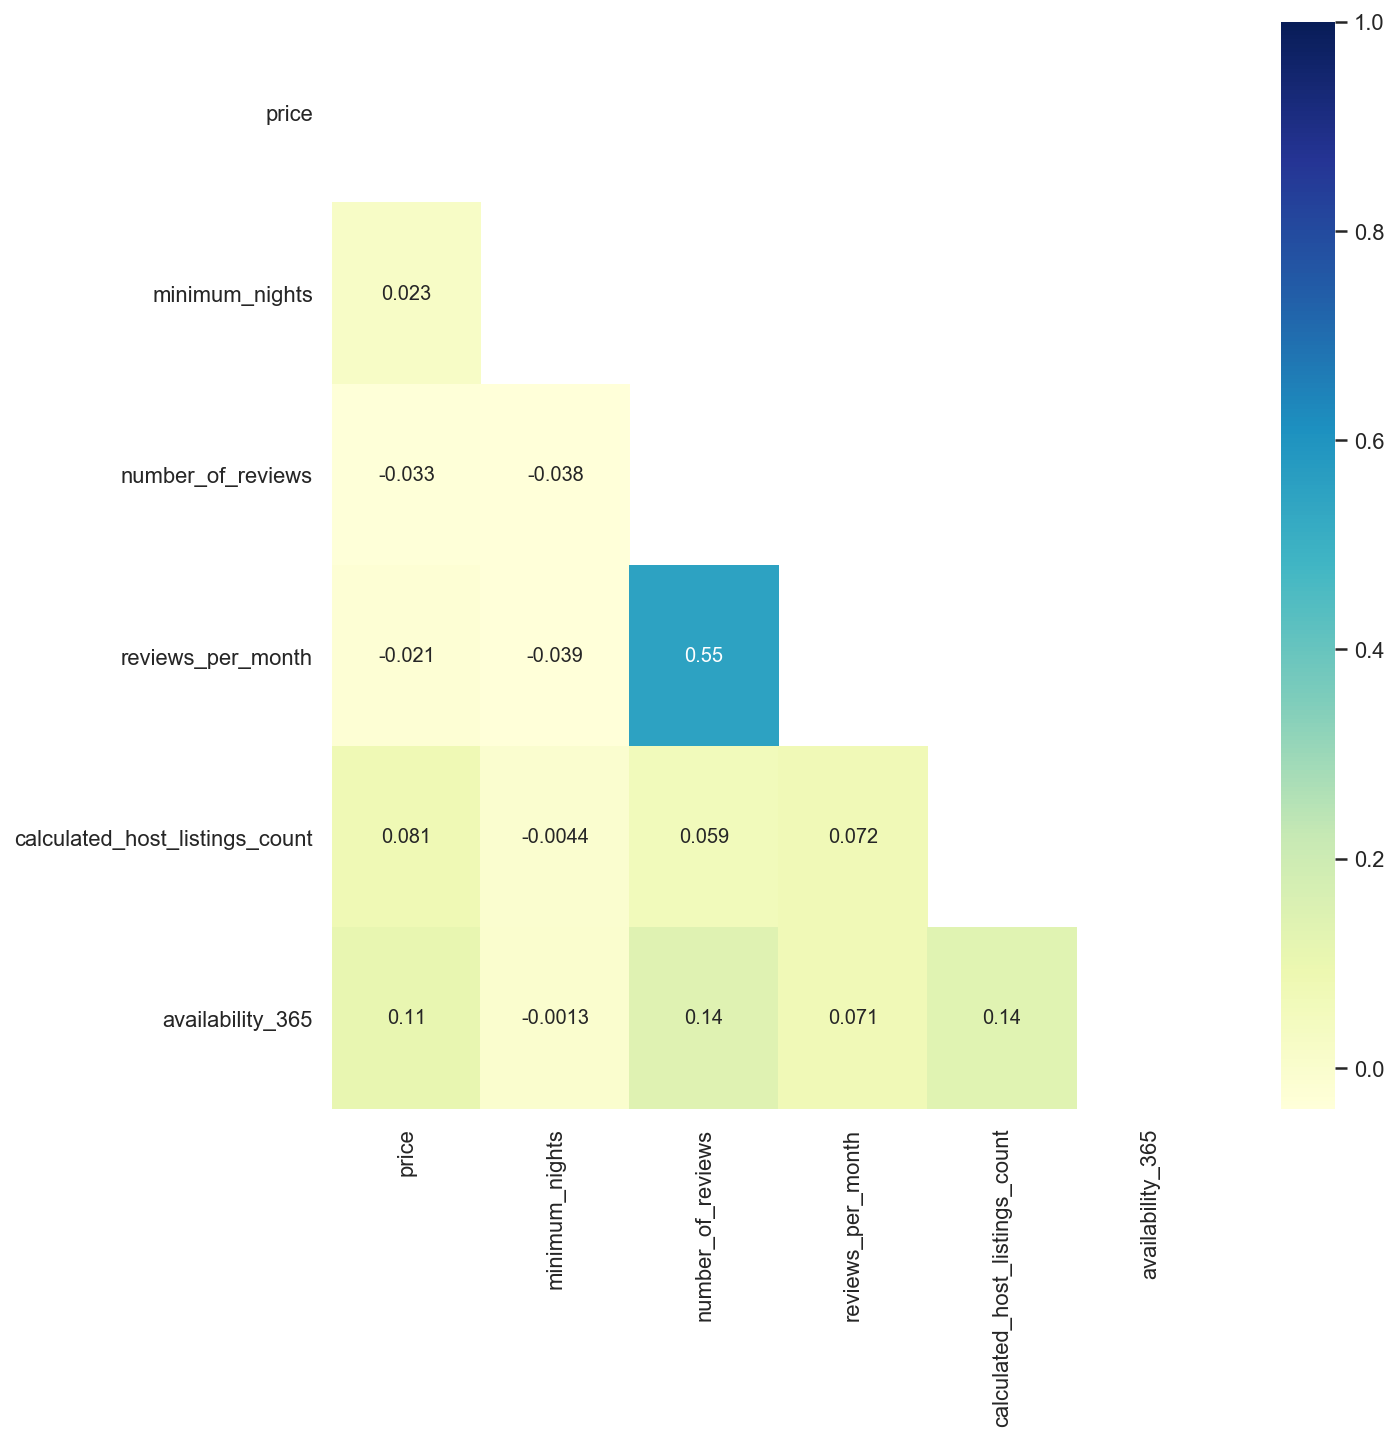

In [13]:
corr = data.corr()
plt.figure(figsize = (10,10))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sb.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,mask=mask,annot=True,cmap="YlGnBu")


In [14]:
# g=sns.pairplot(data,vars=data.columns[0:6],hue=data.columns[6], markers=["s","+"])

In [15]:
data["price"].values

array([ 60,  35, 159, ...,  53, 130, 179])

/Users/Tar/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/Tar/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/Tar/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


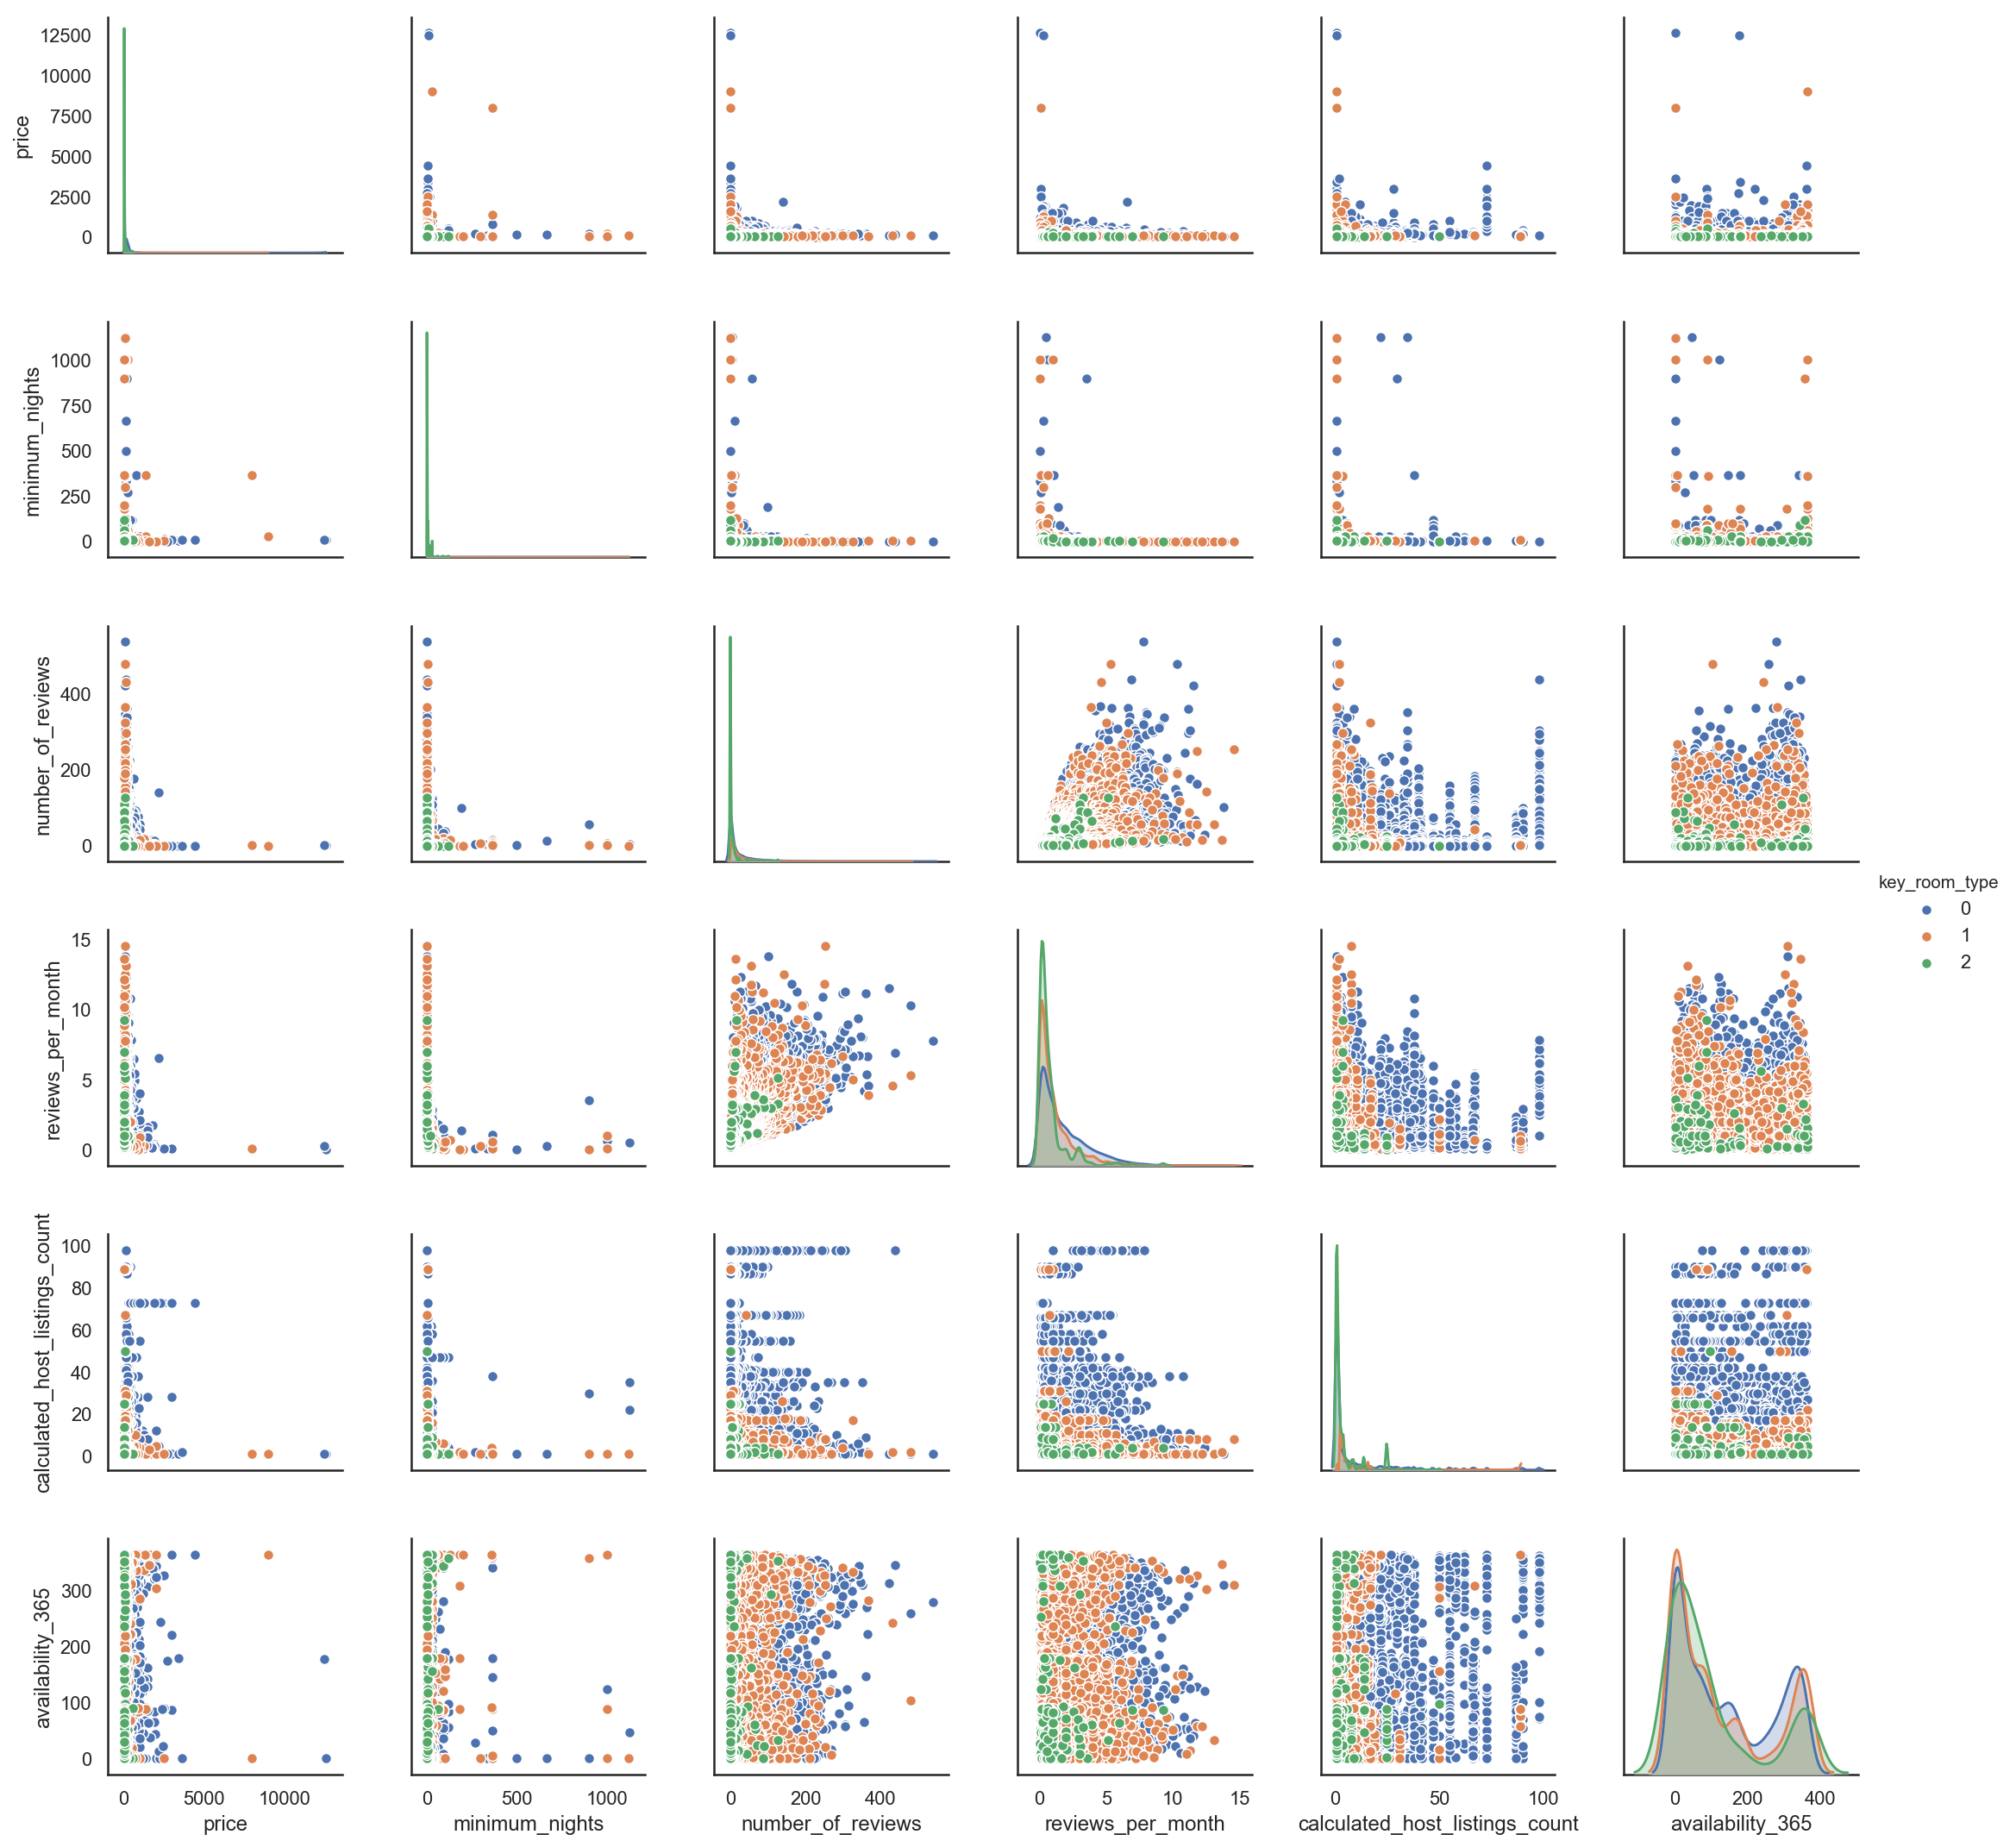

In [16]:
g=sns.pairplot(data_y,vars=data_y.columns[0:6],hue=data_y.columns[7])

In [17]:
data_y.columns[7]

'key_room_type'

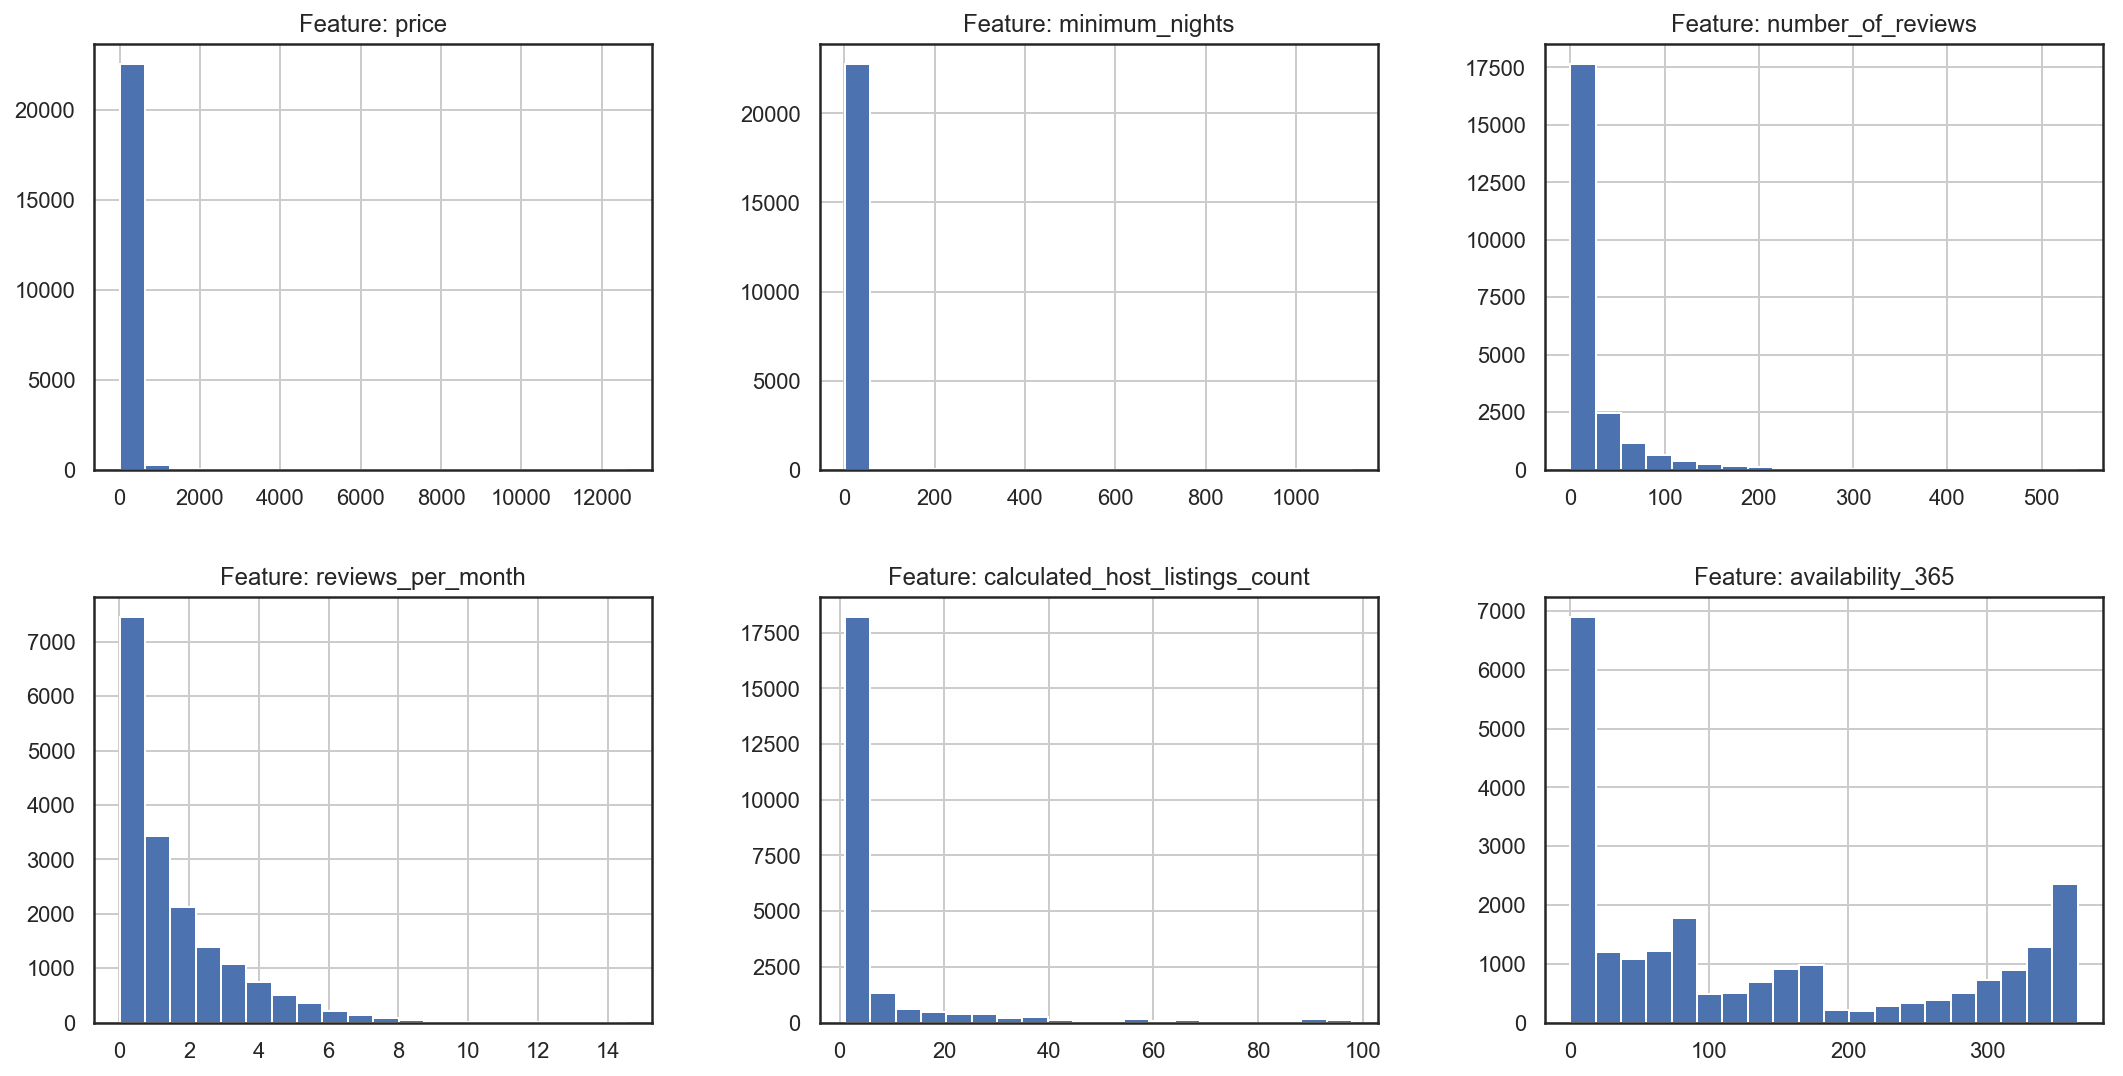

In [18]:

fig, axes = plt.subplots(2, 3, figsize=(18,9))
for i, ax in enumerate(axes.ravel()):
    # your code here
    data_y.hist(ax=ax,column=data_y.columns[i],bins=20)
    ax.set_title("{}: {}".format("Feature", data_y.columns[i]))
plt.show()

# PCA

(22895, 6)
(22895, 2)


Text(0,0.5,'second principal component')

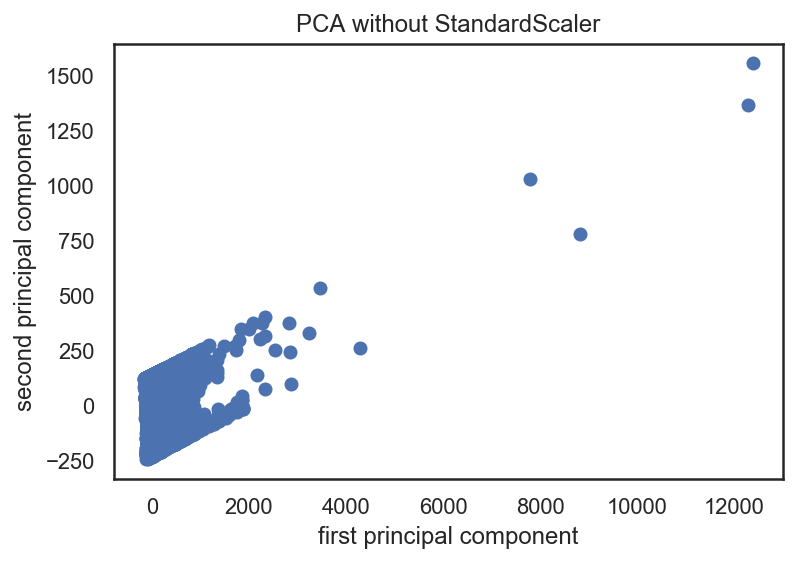

In [20]:
from sklearn.decomposition import PCA
print(data.shape)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data)
# X_pca = pca.fit_transform(data.as_matrix())
print(X_pca.shape)

plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title('PCA without StandardScaler')
plt.xlabel("first principal component")
plt.ylabel("second principal component")

Text(0,0.5,'second principal component')

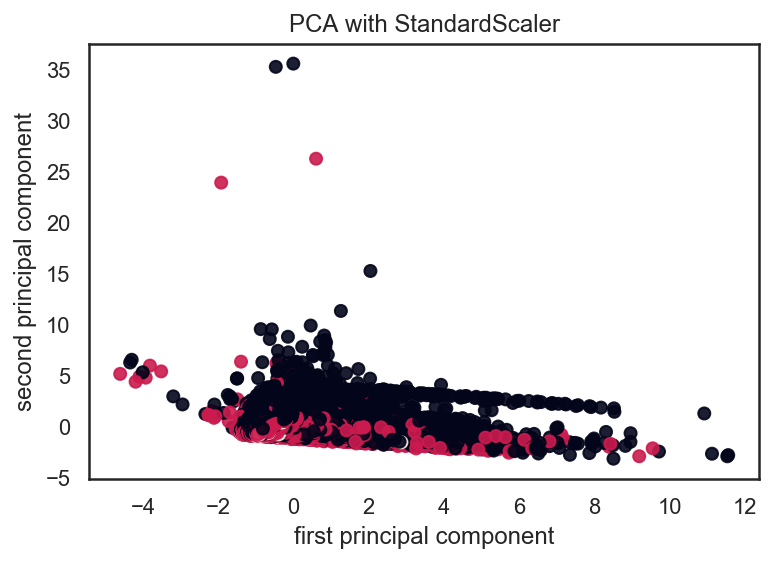

In [21]:
pca_scaled = make_pipeline(StandardScaler(), PCA(n_components=2))
X_pca_scaled = pca_scaled.fit_transform(data)
plt.scatter(X_pca_scaled[:, 0], X_pca_scaled[:, 1], c=target_key_room_type, alpha=.9)

plt.title('PCA with StandardScaler')
plt.xlabel("first principal component")
plt.ylabel("second principal component")

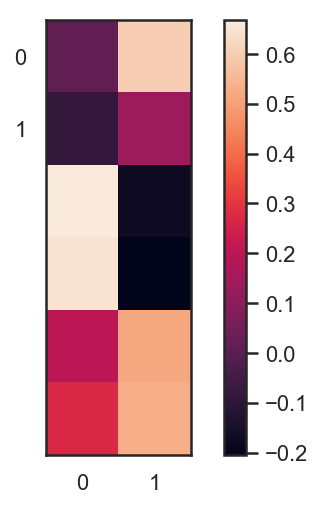

In [22]:
# Component loading
# your code here
pca = pca_scaled.named_steps['pca']
components = pca.components_
plt.imshow(components.T)
plt.yticks(range(X_pca.shape[1]))
plt.colorbar()

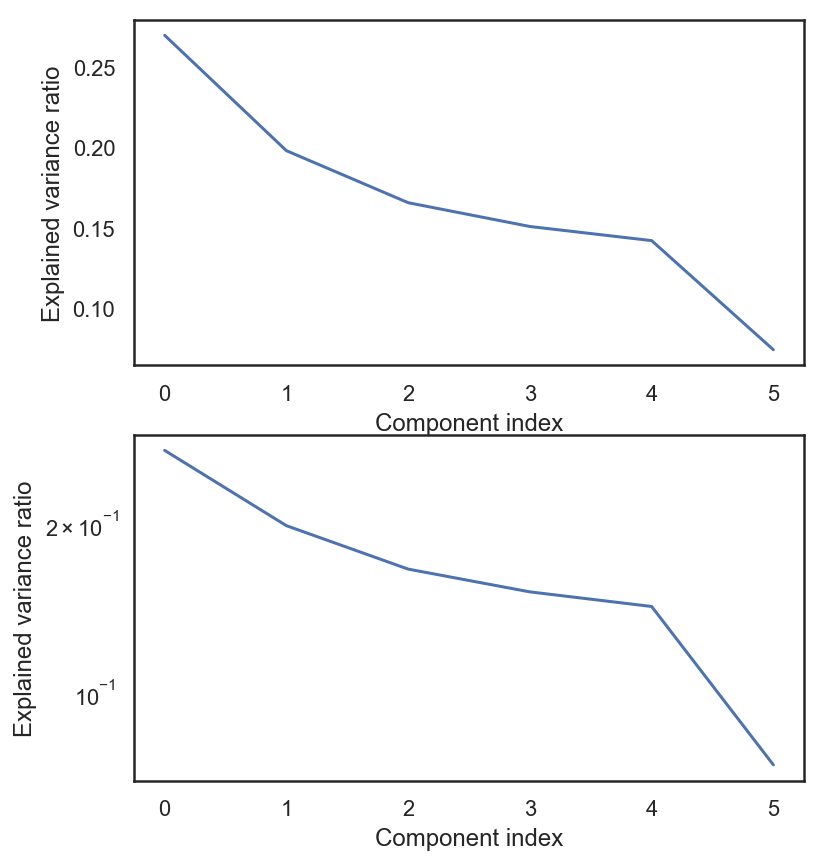

In [23]:
pca_scaled = make_pipeline(StandardScaler(), PCA())
pca_scaled.fit(data,data_y["key_room_type"])
pca = pca_scaled.named_steps['pca']

fig, axes = plt.subplots(2, figsize=(6, 7))
axes[0].plot(pca.explained_variance_ratio_)
axes[1].semilogy(pca.explained_variance_ratio_)
for ax in axes:
    ax.set_xlabel("Component index")
    ax.set_ylabel("Explained variance ratio")